# Implementation of linear discriminant contrast (LDC)
After the RSA workshop this year (2018), I wanted to figure out how the linear discriminant contrast (LDC) works and how it can be implemented in Python. The notebook is the result of that; it's a bit messy, but you'll get the idea hopefully. 

I've based the content of this notebook on [this blog](http://www.johancarlin.com/pilab-tutorial-2-linear-discriminant-contrast.html) and [this presentation](http://www.mrc-cbu.cam.ac.uk/wp-content/uploads/2014/10/rsaworkshop_alex.pdf). I also included the calculation of the LD-t, but I'm not sure that's correct.

In [1]:
import numpy as np
from sklearn.discriminant_analysis import _cov
from nistats.hemodynamic_models import spm_hrf
import matplotlib.pyplot as plt
import seaborn as sns
import scipy

%matplotlib inline

## Generating (relatively) realistic fMRI data
First, let's generate some data. We'll sample onsets of stimuli from 4 conditions ($P$), each with 5 trials/instances ($I$) across a run lasting 300 seconds (5 minutes; $dur$).

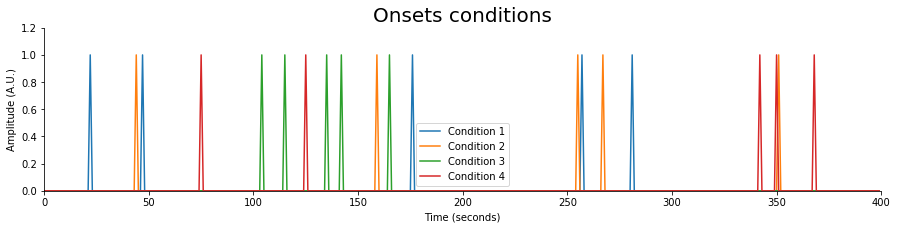

In [2]:
P = 4  # conditions
I = 5   # instances
dur = 400  # duration (in seconds)

X = np.zeros((dur, P))
onsets = np.random.choice(np.arange(dur - 20), size=I*P, replace=False)

i = 0
for p in range(P):
    
    for inst in range(I):
        X[onsets[i], p] = 1
        i += 1

plt.figure(figsize=(15, 3))
plt.plot(X)
plt.title('Onsets conditions', fontsize=20)
plt.xlabel('Time (seconds)')
plt.ylabel('Amplitude (A.U.)')
plt.xlim(0, dur)
plt.ylim(0, 1.2)
plt.legend([f'Condition {p+1}' for p in range(P)], fontsize=10)
sns.despine()
plt.show()

Now, we'll convolve it with an HRF. We'll oversample the HRF by a factor 20. Given that our TR is 2, that means we'll define our HRF at the resolution of 10 Hz.

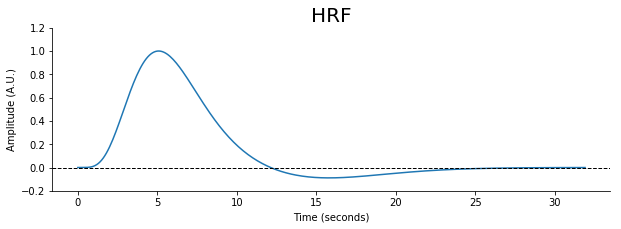

In [4]:
TR = 2

oversampling = 20
hrf = spm_hrf(TR, oversampling=oversampling, time_length=32)

# Scale HRF such that range is [min(hrf), 1]
hrf = hrf / np.max(hrf)

plt.figure(figsize=(10, 3))
plt.plot(np.arange(0, 32, (1/(oversampling/TR))), hrf)
plt.axhline(0, ls='--', c='k', lw=1)
plt.ylim(-0.2, 1.2)
plt.xlabel('Time (seconds)')
plt.ylabel('Amplitude (A.U.)')
plt.title("HRF", fontsize=20)
sns.despine()
plt.show()

To actually convolve the design, we need to upsample our onsets as well (from 1 Hz to 10 Hz):

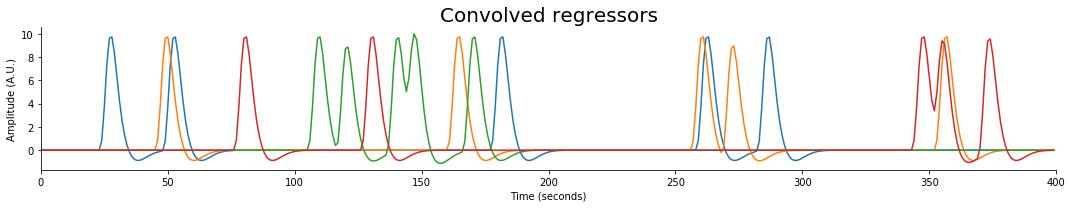

In [5]:
plt.figure(figsize=(15, 3))

us_factor = int(oversampling / TR)
Xus = np.repeat(X, axis=0, repeats=us_factor)
Xconv = np.hstack([np.convolve(Xus[:, i], hrf, 'full')[:dur*us_factor, np.newaxis] for i in range(P)])

# Downsample again to seconds (1 Hz)
Xconv = Xconv[::us_factor, :]
plt.plot(Xconv)
plt.title('Convolved regressors', fontsize=20)
plt.xlabel('Time (seconds)')
plt.ylabel('Amplitude (A.U.)')
plt.xlim(0, dur)

plt.tight_layout()
sns.despine()
plt.show()

We're almost there: we still need to downsample our design-matrix to the resolution of our scans, i.e., the resolution of the TR (0.5 Hz) and add an intercept:

In [6]:
X_final = Xconv[::2, :]
X_final = np.c_[np.ones(X_final.shape[0]), X_final]
print(X_final.shape)

(200, 5)


Alright, now, let's generate the signal ($y$) as follows:

\begin{align}
y = X\beta + \epsilon \sim N(0, V)
\end{align}

First, let's generate the noise (for $K = 4$ voxels):

(200, 4)


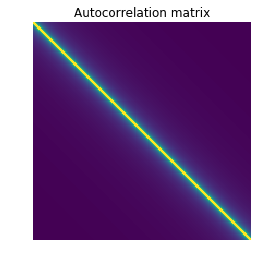

In [7]:
K = 4

# Somewhat realistic covariance matrix of signal
V = 1 / (1 + scipy.linalg.toeplitz(np.arange(dur/TR), np.arange(dur/TR)))
noise = np.random.multivariate_normal(np.zeros(int(dur/TR)), V, size=K).T
print(noise.shape)

plt.imshow(V, vmax=0.5)
plt.title('Autocorrelation matrix')
plt.axis('off')
plt.show()

Now, let's generate the true parameters ($\beta$):

\begin{align}
\beta \sim N(0, 0.15)
\end{align}

In [8]:
# Including intercept
true_params = np.random.normal(0, 0.15, (P+1, K))

Now we can create the signals!

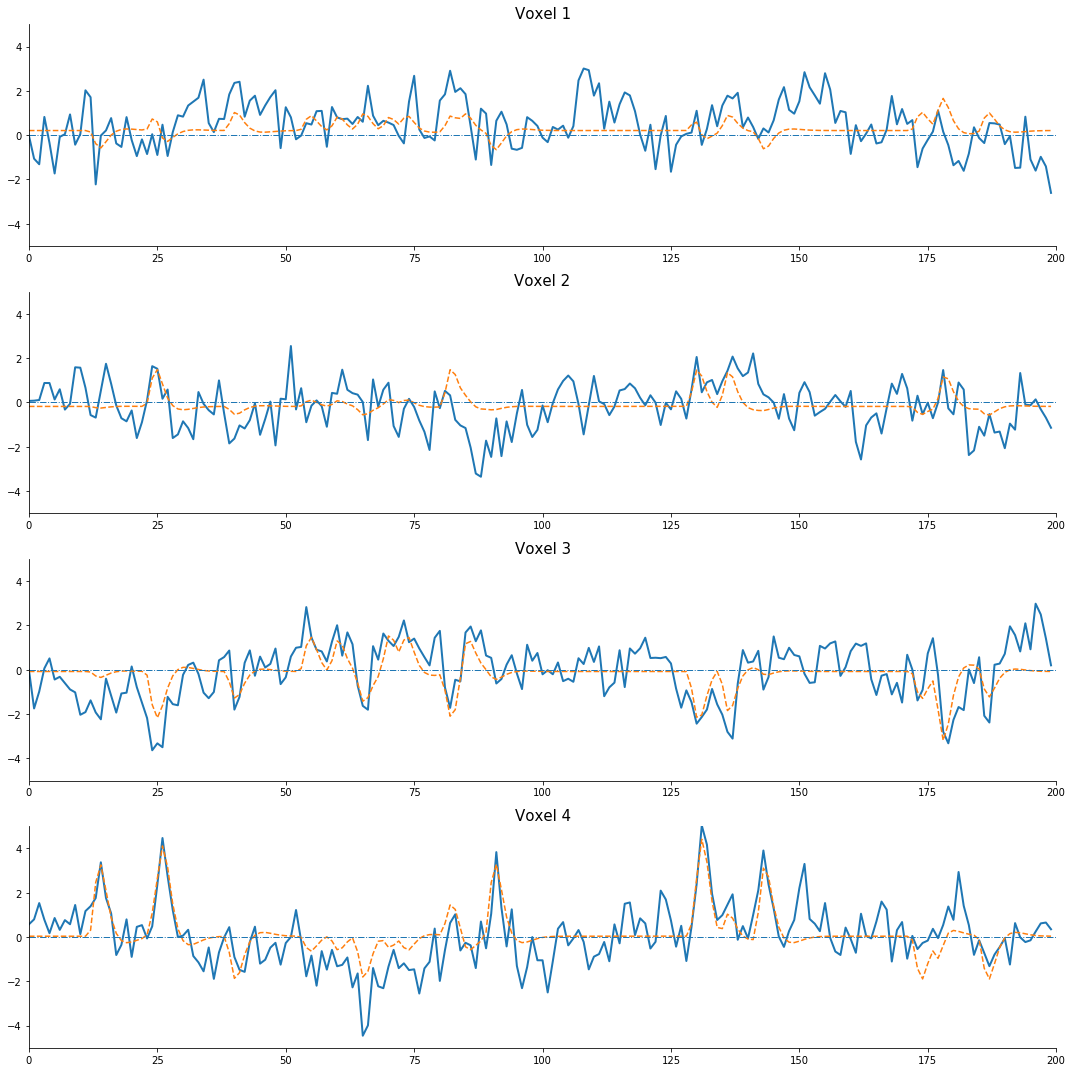

In [9]:
y = X_final.dot(true_params) + noise

plt.figure(figsize=(15, 15))

for k in range(K):
    plt.subplot(K, 1, (k+1))
    plt.plot(y[:, k], lw=2)
    plt.plot(X_final.dot(true_params[:, k]), ls='--')
    plt.xlim(0, 200)
    plt.ylim(-5, 5)
    plt.axhline(0, ls='-.', lw=1)
    plt.title(f"Voxel {k+1}", fontsize=15)
    
sns.despine()
plt.tight_layout()
plt.show()

## Calculating the linear discriminant contrast
The LDC a.k.a. Mahalanobis distance. Note, this is (not yet) the cross-validated version ("crossnobis"); this is explained later.

First, we have to compute the parameters from the linear model:

\begin{align}
\beta = (X^{T}X)^{-1}X^{T}y
\end{align}

In [10]:
est_params = np.linalg.lstsq(X_final, y, rcond=None)[0]

Let's compare it to the true parameters:

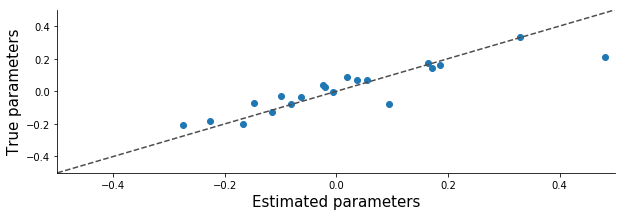

In [11]:
plt.figure(figsize=(10, 3))
plt.scatter(est_params, true_params)
plt.plot([-0.5, 0.5], [-0.5, 0.5], ls="--", c=".3")
plt.xlim(-0.5, 0.5)
plt.ylim(-0.5, 0.5)
plt.xlabel('Estimated parameters', fontsize=15)
plt.ylabel('True parameters', fontsize=15)
sns.despine()
plt.show()

Not bad. ANyway, now we need to calculate the covariance matrix of the features (voxels), $\Omega$. (Here, we use $\Omega$ instead of the more common notation of $V$, because we've used that to denote the covariance matrix across time!) Usually, this covariance matrix is calculated on the residuals of the model ($y - \hat{y}$):

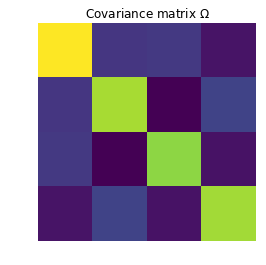

In [12]:
residuals = y - X_final.dot(est_params)
omega = np.cov(residuals.T)

plt.title("Covariance matrix $\Omega$")
plt.imshow(omega)
plt.axis('off')
plt.show()

The next step in LDA is calculate the difference in parameters between two conditions, let' say condition 1 and 2:

In [13]:
diff_c1c2 = est_params[1, :] - est_params[2, :]
print(diff_c1c2)

[-0.13557863 -0.16938876  0.17502224  0.15755565]


A different way to do this is using contrast-vectors. For example, with contrast vector $c = [0, 1, -1, 0, 0]$, we can calculate the same difference of parameters as above (the first 0 in $c$ refers to the intercept):

In [14]:
c = np.array([0, 1, -1, 0, 0])
diff_c1c2 = c.dot(est_params)
diff_c1c2

array([-0.13557863, -0.16938876,  0.17502224,  0.15755565])

Now, the last thing we need to do is calculate the actual LDC/Mahalanobis distance:

\begin{align}
ldc = (\beta_{1} - \beta_{2})\Omega^{-1}(\beta_{1} - \beta_{2})^{T}
\end{align}

In [15]:
diff_c1c2.dot(np.linalg.inv(omega)).dot(diff_c1c2).T

0.10494452961363823

## Cross-validation of ldc
Also known as cross-validated Mahalanobis distance or crossnobis.

In [16]:
def generate_data(P, I, dur, TR, K, true_params):
    """ Generates data.
    
    P : int
        Number of conditions
    I : int
        Number of instances per condition
    dur : int
        Duration of run in seconds
    TR : int
        Time to repetition (for simplicity, can only be an integer)
    K : int
        Number of voxels
    true : list
        True parameters (must be of length P + 1)
    
    Returns
    -------
    y : numpy array
        Array reflecting signal of K voxels of length dur/TR
    X_final : numpy array
        Array reflecting final (convolved) design of length dur/TR by K
    """
    X = np.zeros((dur, P))
    onsets = np.random.choice(np.arange(dur - 20), size=I*P, replace=False)

    i = 0
    for p in range(P):

        for inst in range(I):
            X[onsets[i], p] = 1
            i += 1

    oversampling = 20
    hrf = spm_hrf(TR, oversampling=oversampling, time_length=32)

    # Scale HRF such that range is [min(hrf), 1]
    hrf = hrf / np.max(hrf)

    us_factor = int(oversampling / TR)
    Xus = np.repeat(X, axis=0, repeats=us_factor)
    Xconv = np.hstack([np.convolve(Xus[:, i], hrf, 'full')[:dur*us_factor, np.newaxis] for i in range(P)])

    # Downsample again to seconds (1 Hz)
    Xconv = Xconv[::us_factor, :]

    X_final = Xconv[::TR, :]
    X_final = np.c_[np.ones(X_final.shape[0]), X_final]

    # Somewhat realistic covariance matrix of signal
    V = 1 / (1 + scipy.linalg.toeplitz(np.arange(dur/TR), np.arange(dur/TR)))
    noise = np.random.multivariate_normal(np.zeros(int(dur/TR)), V, size=K).T

    true_params = np.array(true_params)[:, np.newaxis]
    y = X_final.dot(true_params) + noise
    return y, X_final

We'll simulate two runs:

In [17]:
#true_params = np.random.normal(0, 0.15, 3)
true_params = np.array([0, 0, 0])
y1, X1 = generate_data(P=2, I=6, dur=300, TR=2, K=10, true_params=true_params)
y2, X2 = generate_data(P=2, I=6, dur=300, TR=2, K=10, true_params=true_params)

So, the idea is that for two runs, let's say R1 and R2, the cross-validated Mahalanobis distance between condition A and B is:

\begin{align}
\delta_{Mahalanobis}(A, B) = (\beta_{A} - \beta_{B})_{R1}\Omega^{-1}_{R1}(\beta_{A} - \beta_{B})_{R2}^{T}
\end{align}

While we're at it, let's also apply shrinkage to our covariance matrix of the residuals ($\Omega$), which is often recommended. We'll do that using the `cov` function from the scikit-learn package:

In [18]:
from sklearn.discriminant_analysis import _cov

params_R1 = np.linalg.lstsq(X1, y1, rcond=None)[0]
residuals_R1 = y1 - X1.dot(params_R1)
omega_R1 = _cov(residuals_R1, shrinkage='auto')

params_R2 = np.linalg.lstsq(X2, y2, rcond=None)[0]

cv_ldc = (params_R1[1, :] - params_R2[2, :]).dot(omega_R1).dot((params_R1[1, :] - params_R2[2, :]).T)
cv_ldc

0.026289009884526548

So, supposedly you can also calculate a t-value of your LDC statistic as follows:

\begin{align}
LD_{t} = \frac{ldc}{\sqrt(\mathbf{w}\Omega_{R2}\mathbf{w}^{T}) * c(\mathbf{X}^{T}\mathbf{X})^{-1}c^{T}})
\end{align}

Here, $\mathbf{w}$ is the weight vector for optimal separation of the two classes:

\begin{align}
\mathbf{w} = (\beta_{A} - \beta_{B})\Omega^{-1}
\end{align}

and $c$ is the contrast-vector defining which conditions are compared. So, we can calculate this LD-t as follows:

In [20]:
residuals_R2 = y2 - X2.dot(params_R2)
omega_R2 = _cov(residuals_R2, shrinkage='auto')
w = (params_R1[1, :] - params_R2[2, :]).dot(omega_R1)
c = np.array([0, 1, -1])
ldT = cv_ldc / np.sqrt(w.dot(omega_R2).dot(w.T) * c.dot(np.linalg.inv(X1.T.dot(X1))).dot(c.T))
ldT # this is probably not correct

4.203573427129181